In [1]:
!pip install gdown

In [1]:
# https://drive.google.com/file/d/1-5fOSHOSB9UXyP_enOoZNAMScrePVcMD/view
# downloading the model direclty from google drive 

import gdown

file_id = "1-5fOSHOSB9UXyP_enOoZNAMScrePVcMD"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, output="model_file.pt", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-5fOSHOSB9UXyP_enOoZNAMScrePVcMD
From (redirected): https://drive.google.com/uc?id=1-5fOSHOSB9UXyP_enOoZNAMScrePVcMD&confirm=t&uuid=dcd07fc3-936d-4888-92f2-5c00045d9e55
To: /kaggle/working/model_file.pt
100%|██████████| 195M/195M [00:00<00:00, 207MB/s] 


'model_file.pt'

In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, deque
import pickle
import os
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'false')
print(device)

cuda


In [6]:
model_path = "/kaggle/working/model_file.pt"
broadcast_video = "/kaggle/input/videos/broadcast.mp4"
tacticam_video = "/kaggle/input/videos/tacticam.mp4"

In [7]:
# Verify files exist
for path in [model_path,broadcast_video,tacticam_video]:
    if os.path.exists(path):
        print(f"✓ Found: {path}")
    else:
        print(f"✗ Missing: {path}")

✓ Found: /kaggle/working/model_file.pt
✓ Found: /kaggle/input/videos/broadcast.mp4
✓ Found: /kaggle/input/videos/tacticam.mp4


In [8]:
model = YOLO(model_path)
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [12]:
class CrossCameraPlayerMapper:
    def __init__(self, model):
        self.model = model
        self.broadcast_detections = []
        self.tacticam_detections = []
        self.broadcast_tracks = []
        self.tacticam_tracks = []
        self.player_mappings = {}
        self.confidence_threshold = 0.25  # Lowered threshold
        self.tracking_threshold = 150  # Increased threshold for tracking
        
    def detect_players(self, video_path, camera_type, max_frames=200):
        """
        Detect players in video using YOLOv11 with extensive debugging
        """
        print(f"\n🎯 Processing {camera_type} camera...")
        
        # Check video file
        if not os.path.exists(video_path):
            print(f"❌ Video file not found: {video_path}")
            return []
        
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"❌ Cannot open video: {video_path}")
            return []
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        print(f"📹 Video info: {total_frames} frames, {fps:.1f} FPS, {width}x{height}")
        
        # Process fewer frames but more thoroughly
        frames_to_process = min(total_frames, max_frames)
        skip_frames = max(1, total_frames // frames_to_process)
        
        detections = []
        frame_count = 0
        processed_frames = 0
        total_detections = 0
        
        while frame_count < total_frames and processed_frames < frames_to_process:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Skip frames for efficiency
            if frame_count % skip_frames != 0:
                frame_count += 1
                continue
            
            # Run YOLO detection with lower confidence
            try:
                results = self.model(frame, conf=self.confidence_threshold, verbose=False)
                
                frame_detections = []
                for result in results:
                    if result.boxes is not None:
                        for box in result.boxes:
                            cls = int(box.cls[0])
                            confidence = float(box.conf[0])
                            
                            # Check all classes, not just person (0)
                            if cls == 0 or confidence > 0.5:  # Person class or high confidence
                                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                                w, h = x2 - x1, y2 - y1
                                
                                # More lenient size filter
                                if w > 15 and h > 25:
                                    detection = {
                                        'bbox': [float(x1), float(y1), float(x2), float(y2)],
                                        'center': [float((x1 + x2) / 2), float((y1 + y2) / 2)],
                                        'width': float(w),
                                        'height': float(h),
                                        'confidence': confidence,
                                        'class': cls,
                                        'frame_idx': processed_frames,
                                        'timestamp': frame_count / fps
                                    }
                                    frame_detections.append(detection)
                                    total_detections += 1
                
                detections.append(frame_detections)
                processed_frames += 1
                frame_count += 1
                
                # More frequent progress updates
                if processed_frames % 25 == 0:
                    print(f"   Frame {processed_frames}/{frames_to_process}: {len(frame_detections)} detections")
                    
            except Exception as e:
                print(f"❌ Error processing frame {frame_count}: {e}")
                detections.append([])
                processed_frames += 1
                frame_count += 1
        
        cap.release()
        
        # Store detections
        if camera_type == 'broadcast':
            self.broadcast_detections = detections
        else:
            self.tacticam_detections = detections
        
        print(f"✅ Total detections: {total_detections} across {len(detections)} frames")
        print(f"📊 Average detections per frame: {total_detections/len(detections):.1f}")
        
        # Show detection statistics
        non_empty_frames = sum(1 for frame in detections if len(frame) > 0)
        print(f"📈 Non-empty frames: {non_empty_frames}/{len(detections)}")
        
        return detections
    
    def extract_player_features(self, detection, frame_shape=(1080, 1920)):
        """
        Extract comprehensive features for player matching
        """
        center_x, center_y = detection['center']
        width, height = detection['width'], detection['height']
        confidence = detection['confidence']
        
        # Normalize features
        norm_x = center_x / frame_shape[1]
        norm_y = center_y / frame_shape[0]
        norm_w = width / frame_shape[1]
        norm_h = height / frame_shape[0]
        
        features = [
            norm_x, norm_y,                    # Position (2 features)
            norm_w, norm_h,                    # Size (2 features)
            width / height if height > 0 else 1,  # Aspect ratio (1 feature)
            (width * height) / (frame_shape[0] * frame_shape[1]),  # Normalized area (1 feature)
            confidence,                        # Confidence (1 feature)
            norm_y + norm_h,                  # Bottom position (1 feature)
            center_x / frame_shape[1],        # Horizontal position weight (1 feature)
            1 - (center_y / frame_shape[0]),  # Vertical position weight (1 feature)
        ]
        
        return np.array(features)
    
    def track_players_in_video(self, detections, camera_type):
        """
        Track players with improved algorithm
        """
        print(f"\n🔄 Tracking players in {camera_type} video...")
        
        if not detections or not any(detections):
            print("❌ No detections to track!")
            return []
        
        tracks = []
        active_tracks = []
        next_id = 1
        
        for frame_idx, frame_detections in enumerate(detections):
            # Handle empty frames
            if not frame_detections:
                tracks.append([])
                continue
            
            # First frame - initialize all tracks
            if frame_idx == 0:
                for det in frame_detections:
                    det['player_id'] = next_id
                    next_id += 1
                    active_tracks.append(det)
                tracks.append(frame_detections)
                continue
            
            # Subsequent frames - match detections to tracks
            if active_tracks:
                # Create distance matrix
                cost_matrix = np.zeros((len(active_tracks), len(frame_detections)))
                
                for i, track in enumerate(active_tracks):
                    for j, det in enumerate(frame_detections):
                        # Multiple distance metrics
                        center_dist = np.sqrt(
                            (track['center'][0] - det['center'][0])**2 + 
                            (track['center'][1] - det['center'][1])**2
                        )
                        
                        # Size difference
                        size_diff = abs(track['width'] - det['width']) + abs(track['height'] - det['height'])
                        
                        # Combined cost
                        cost = center_dist + size_diff * 0.1
                        cost_matrix[i, j] = cost
                
                # Solve assignment problem
                if cost_matrix.size > 0:
                    try:
                        row_ind, col_ind = linear_sum_assignment(cost_matrix)
                        
                        # Update matched tracks
                        new_active_tracks = []
                        matched_detections = set()
                        
                        for i, j in zip(row_ind, col_ind):
                            if cost_matrix[i, j] < self.tracking_threshold:
                                frame_detections[j]['player_id'] = active_tracks[i]['player_id']
                                new_active_tracks.append(frame_detections[j])
                                matched_detections.add(j)
                        
                        # Create new tracks for unmatched detections
                        for j, det in enumerate(frame_detections):
                            if j not in matched_detections:
                                det['player_id'] = next_id
                                next_id += 1
                                new_active_tracks.append(det)
                        
                        active_tracks = new_active_tracks
                        
                    except Exception as e:
                        print(f"Warning: Assignment failed at frame {frame_idx}: {e}")
                        # Fallback: assign new IDs
                        for det in frame_detections:
                            det['player_id'] = next_id
                            next_id += 1
                        active_tracks = frame_detections
                else:
                    # No cost matrix, create new tracks
                    for det in frame_detections:
                        det['player_id'] = next_id
                        next_id += 1
                    active_tracks = frame_detections
            else:
                # No active tracks, create new ones
                for det in frame_detections:
                    det['player_id'] = next_id
                    next_id += 1
                active_tracks = frame_detections
            
            tracks.append(frame_detections)
        
        # Store tracks
        if camera_type == 'broadcast':
            self.broadcast_tracks = tracks
        else:
            self.tacticam_tracks = tracks
        
        # Count unique players
        unique_players = set()
        for frame_tracks in tracks:
            for track in frame_tracks:
                unique_players.add(track['player_id'])
        
        print(f"✅ Tracked {len(unique_players)} unique players across {len(tracks)} frames")
        
        # Show tracking statistics
        total_tracked = sum(len(frame) for frame in tracks)
        print(f"📊 Total tracked detections: {total_tracked}")
        
        return tracks
    
    def create_player_trajectories(self, tracks):
        """
        Create trajectories for each player with debugging
        """
        trajectories = defaultdict(list)
        
        for frame_idx, frame_tracks in enumerate(tracks):
            for track in frame_tracks:
                if 'player_id' in track:
                    player_id = track['player_id']
                    trajectories[player_id].append({
                        'frame': frame_idx,
                        'center': track['center'],
                        'features': self.extract_player_features(track),
                        'timestamp': track.get('timestamp', frame_idx),
                        'confidence': track.get('confidence', 0.5)
                    })
        
        print(f"📍 Created trajectories for {len(trajectories)} players")
        for pid, traj in trajectories.items():
            print(f"   Player {pid}: {len(traj)} trajectory points")
        
        return trajectories
    
    def compute_trajectory_similarity(self, traj1, traj2, min_overlap=3):
        """
        Compute similarity with more robust matching
        """
        if len(traj1) < min_overlap or len(traj2) < min_overlap:
            return 0.0
        
        # Find temporal overlap
        frames1 = {point['frame'] for point in traj1}
        frames2 = {point['frame'] for point in traj2}
        common_frames = frames1.intersection(frames2)
        
        if len(common_frames) < min_overlap:
            # Try relaxed temporal matching
            all_frames = sorted(frames1.union(frames2))
            matched_pairs = []
            
            for point1 in traj1:
                for point2 in traj2:
                    frame_diff = abs(point1['frame'] - point2['frame'])
                    if frame_diff <= 2:  # Allow 2-frame tolerance
                        matched_pairs.append((point1, point2))
            
            if len(matched_pairs) < min_overlap:
                return 0.0
            
            # Use matched pairs for similarity
            features1 = [p[0]['features'] for p in matched_pairs]
            features2 = [p[1]['features'] for p in matched_pairs]
        else:
            # Use exact frame matches
            features1, features2 = [], []
            for frame in sorted(common_frames):
                point1 = next((p for p in traj1 if p['frame'] == frame), None)
                point2 = next((p for p in traj2 if p['frame'] == frame), None)
                
                if point1 and point2:
                    features1.append(point1['features'])
                    features2.append(point2['features'])
        
        if len(features1) < min_overlap:
            return 0.0
        
        # Compute multiple similarity metrics
        features1 = np.array(features1)
        features2 = np.array(features2)
        
        # 1. Cosine similarity of average features
        avg_features1 = np.mean(features1, axis=0)
        avg_features2 = np.mean(features2, axis=0)
        cosine_sim = cosine_similarity([avg_features1], [avg_features2])[0][0]
        
        # 2. Euclidean distance similarity
        euclidean_dist = np.linalg.norm(avg_features1 - avg_features2)
        euclidean_sim = 1.0 / (1.0 + euclidean_dist)
        
        # 3. Correlation similarity
        correlation_sim = 0.0
        if len(features1) > 1:
            try:
                correlations = []
                for i in range(features1.shape[1]):
                    if np.std(features1[:, i]) > 0 and np.std(features2[:, i]) > 0:
                        corr = np.corrcoef(features1[:, i], features2[:, i])[0, 1]
                        if not np.isnan(corr):
                            correlations.append(abs(corr))
                if correlations:
                    correlation_sim = np.mean(correlations)
            except:
                correlation_sim = 0.0
        
        # Combined similarity
        combined_sim = 0.4 * cosine_sim + 0.3 * euclidean_sim + 0.3 * correlation_sim
        
        # Bonus for longer trajectories
        length_bonus = min(len(features1) / 20, 0.1)
        
        return max(0, combined_sim + length_bonus)
    
    def establish_player_mapping(self, similarity_threshold=0.3):
        """
        Establish mapping with lower threshold and better debugging
        """
        print("\n🔗 Establishing cross-camera player mapping...")
        
        # Check if we have tracks
        if not self.broadcast_tracks or not self.tacticam_tracks:
            print("❌ No tracks available for mapping!")
            return {}, {}
        
        # Create trajectories
        broadcast_trajectories = self.create_player_trajectories(self.broadcast_tracks)
        tacticam_trajectories = self.create_player_trajectories(self.tacticam_tracks)
        
        if not broadcast_trajectories or not tacticam_trajectories:
            print("❌ No trajectories created!")
            return {}, {}
        
        print(f"📊 Broadcast players: {len(broadcast_trajectories)}")
        print(f"📊 Tactical players: {len(tacticam_trajectories)}")
        
        # Compute similarity matrix
        b_players = list(broadcast_trajectories.keys())
        t_players = list(tacticam_trajectories.keys())
        
        print(f"🔍 Computing similarity matrix ({len(b_players)} x {len(t_players)})...")
        
        similarity_matrix = np.zeros((len(b_players), len(t_players)))
        
        for i, b_player in enumerate(b_players):
            for j, t_player in enumerate(t_players):
                similarity = self.compute_trajectory_similarity(
                    broadcast_trajectories[b_player],
                    tacticam_trajectories[t_player]
                )
                similarity_matrix[i, j] = similarity
                
                if similarity > 0.1:  # Log significant similarities
                    print(f"   B{b_player} vs T{t_player}: {similarity:.3f}")
        
        print(f"📈 Similarity matrix shape: {similarity_matrix.shape}")
        print(f"📈 Max similarity: {np.max(similarity_matrix):.3f}")
        print(f"📈 Mean similarity: {np.mean(similarity_matrix):.3f}")
        
        # Find optimal mapping using Hungarian algorithm
        try:
            row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # Negative for max assignment
            
            # Create mapping dictionary
            mapping = {}
            mapping_scores = {}
            
            for i, j in zip(row_ind, col_ind):
                similarity_score = similarity_matrix[i, j]
                if similarity_score > similarity_threshold:
                    broadcast_id = b_players[i]
                    tacticam_id = t_players[j]
                    mapping[broadcast_id] = tacticam_id
                    mapping_scores[broadcast_id] = similarity_score
                    print(f"✅ Mapped B{broadcast_id} -> T{tacticam_id} (score: {similarity_score:.3f})")
            
            self.player_mappings = mapping
            
            print(f"🎯 Successfully mapped {len(mapping)} players")
            
        except Exception as e:
            print(f"❌ Error in mapping: {e}")
            mapping, mapping_scores = {}, {}
        
        return mapping, mapping_scores
    
    def visualize_results(self):
        """
        Create comprehensive visualizations
        """
        print("\n📊 Creating visualizations...")
        
        try:
            # Create subplots
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Cross-Camera Player Mapping Results', fontsize=16, fontweight='bold')
            
            # Plot 1: Player counts per frame
            broadcast_counts = [len(frame) for frame in self.broadcast_tracks]
            tacticam_counts = [len(frame) for frame in self.tacticam_tracks]
            
            axes[0, 0].plot(broadcast_counts, label='Broadcast', linewidth=2, marker='o', markersize=2)
            axes[0, 0].plot(tacticam_counts, label='Tactical', linewidth=2, marker='s', markersize=2)
            axes[0, 0].set_title('Players Detected Per Frame')
            axes[0, 0].set_xlabel('Frame')
            axes[0, 0].set_ylabel('Number of Players')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Plot 2: Mapping visualization
            if self.player_mappings:
                broadcast_ids = list(self.player_mappings.keys())
                tacticam_ids = list(self.player_mappings.values())
                
                axes[0, 1].scatter(broadcast_ids, tacticam_ids, s=100, alpha=0.7, c='red')
                for b_id, t_id in zip(broadcast_ids, tacticam_ids):
                    axes[0, 1].annotate(f'{b_id}→{t_id}', (b_id, t_id), xytext=(5, 5), 
                                       textcoords='offset points', fontsize=10)
                axes[0, 1].set_title('Player ID Mapping')
                axes[0, 1].set_xlabel('Broadcast Player ID')
                axes[0, 1].set_ylabel('Tactical Player ID')
                axes[0, 1].grid(True, alpha=0.3)
            else:
                axes[0, 1].text(0.5, 0.5, 'No Mappings Found', ha='center', va='center', 
                               transform=axes[0, 1].transAxes, fontsize=14)
                axes[0, 1].set_title('Player ID Mapping (Empty)')
            
            # Plot 3: Detection confidence distribution
            broadcast_conf = []
            tacticam_conf = []
            
            for frame in self.broadcast_tracks:
                broadcast_conf.extend([det.get('confidence', 0.5) for det in frame])
            for frame in self.tacticam_tracks:
                tacticam_conf.extend([det.get('confidence', 0.5) for det in frame])
            
            if broadcast_conf:
                axes[1, 0].hist(broadcast_conf, bins=20, alpha=0.7, label='Broadcast', density=True)
            if tacticam_conf:
                axes[1, 0].hist(tacticam_conf, bins=20, alpha=0.7, label='Tactical', density=True)
            
            axes[1, 0].set_title('Detection Confidence Distribution')
            axes[1, 0].set_xlabel('Confidence Score')
            axes[1, 0].set_ylabel('Density')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            
            # Plot 4: Summary statistics
            axes[1, 1].axis('off')
            
            # Create summary text
            summary_text = f"""
            DETECTION SUMMARY:
            • Broadcast frames: {len(self.broadcast_tracks)}
            • Tactical frames: {len(self.tacticam_tracks)}
            • Total broadcast detections: {sum(len(f) for f in self.broadcast_tracks)}
            • Total tactical detections: {sum(len(f) for f in self.tacticam_tracks)}
            
            TRACKING SUMMARY:
            • Broadcast unique players: {len(set(d['player_id'] for f in self.broadcast_tracks for d in f if 'player_id' in d))}
            • Tactical unique players: {len(set(d['player_id'] for f in self.tacticam_tracks for d in f if 'player_id' in d))}
            
            MAPPING SUMMARY:
            • Successfully mapped: {len(self.player_mappings)}
            • Mapping rate: {len(self.player_mappings)/max(1, len(set(d['player_id'] for f in self.broadcast_tracks for d in f if 'player_id' in d)))*100:.1f}%
            """
            
            axes[1, 1].text(0.1, 0.9, summary_text, transform=axes[1, 1].transAxes, 
                            fontsize=11, verticalalignment='top', fontfamily='monospace')
            axes[1, 1].set_title('Summary Statistics')
            
            plt.tight_layout()
            plt.savefig('/kaggle/working/player_mapping_results.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except Exception as e:
            print(f"❌ Error creating visualizations: {e}")
    
    def save_results(self):
        """
        Save all results with comprehensive information
        """
        print("\n💾 Saving results...")
        
        try:
            # Save mapping dictionary
            with open('/kaggle/working/player_mappings.pkl', 'wb') as f:
                pickle.dump(self.player_mappings, f)
            
            # Create detailed results DataFrame
            results_data = []
            
            if self.player_mappings:
                broadcast_traj = self.create_player_trajectories(self.broadcast_tracks)
                tacticam_traj = self.create_player_trajectories(self.tacticam_tracks)
                
                for broadcast_id, tacticam_id in self.player_mappings.items():
                    b_frames = len(broadcast_traj.get(broadcast_id, []))
                    t_frames = len(tacticam_traj.get(tacticam_id, []))
                    
                    similarity = self.compute_trajectory_similarity(
                        broadcast_traj.get(broadcast_id, []), 
                        tacticam_traj.get(tacticam_id, [])
                    )
                    
                    results_data.append({
                        'broadcast_player_id': broadcast_id,
                        'tacticam_player_id': tacticam_id,
                        'broadcast_trajectory_length': b_frames,
                        'tacticam_trajectory_length': t_frames,
                        'mapping_confidence': similarity
                    })
            
            # Add summary statistics
            summary_data = {
                'total_broadcast_detections': sum(len(f) for f in self.broadcast_tracks),
                'total_tacticam_detections': sum(len(f) for f in self.tacticam_tracks),
                'broadcast_unique_players': len(set(d['player_id'] for f in self.broadcast_tracks for d in f if 'player_id' in d)),
                'tacticam_unique_players': len(set(d['player_id'] for f in self.tacticam_tracks for d in f if 'player_id' in d)),
                'successful_mappings': len(self.player_mappings)
            }
            
            # Save results
            if results_data:
                results_df = pd.DataFrame(results_data)
                results_df.to_csv('/kaggle/working/player_mapping_results.csv', index=False)
            else:
                # Create empty results file with explanation
                empty_df = pd.DataFrame(columns=['broadcast_player_id', 'tacticam_player_id', 
                                               'broadcast_trajectory_length', 'tacticam_trajectory_length', 
                                               'mapping_confidence'])
                empty_df.to_csv('/kaggle/working/player_mapping_results.csv', index=False)
            
            # Save summary
            with open('/kaggle/working/mapping_summary.txt', 'w') as f:
                f.write("CROSS-CAMERA PLAYER MAPPING SUMMARY\n")
                f.write("=" * 40 + "\n\n")
                for key, value in summary_data.items():
                    f.write(f"{key}: {value}\n")
                f.write(f"\nPlayer mappings: {self.player_mappings}\n")
            
            print("✅ Results saved to:")
            print("   - /kaggle/working/player_mappings.pkl")
            print("   - /kaggle/working/player_mapping_results.csv") 
            print("   - /kaggle/working/mapping_summary.txt")
            print("   - /kaggle/working/player_mapping_results.png")
            
            return results_data, summary_data
            
        except Exception as e:
            print(f"❌ Error saving results: {e}")
            return [], {}


In [10]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================


🚀 Starting Cross-Camera Player Mapping

📹 STEP 1: Detecting players in both videos
----------------------------------------

🎯 Processing broadcast camera...
📹 Video info: 132 frames, 24.8 FPS, 1920x1080
   Frame 25/132: 14 detections
   Frame 50/132: 10 detections
   Frame 75/132: 13 detections
   Frame 100/132: 10 detections
   Frame 125/132: 10 detections
✅ Total detections: 1487 across 132 frames
📊 Average detections per frame: 11.3
📈 Non-empty frames: 125/132

🎯 Processing tacticam camera...
📹 Video info: 201 frames, 24.6 FPS, 1920x1080
   Frame 25/200: 20 detections
   Frame 50/200: 23 detections
   Frame 75/200: 23 detections
   Frame 100/200: 22 detections
   Frame 125/200: 21 detections
   Frame 150/200: 22 detections
   Frame 175/200: 19 detections
   Frame 200/200: 22 detections
✅ Total detections: 4309 across 200 frames
📊 Average detections per frame: 21.5
📈 Non-empty frames: 200/200

🎯 STEP 2: Tracking players within each video
----------------------------------------

🔄 T

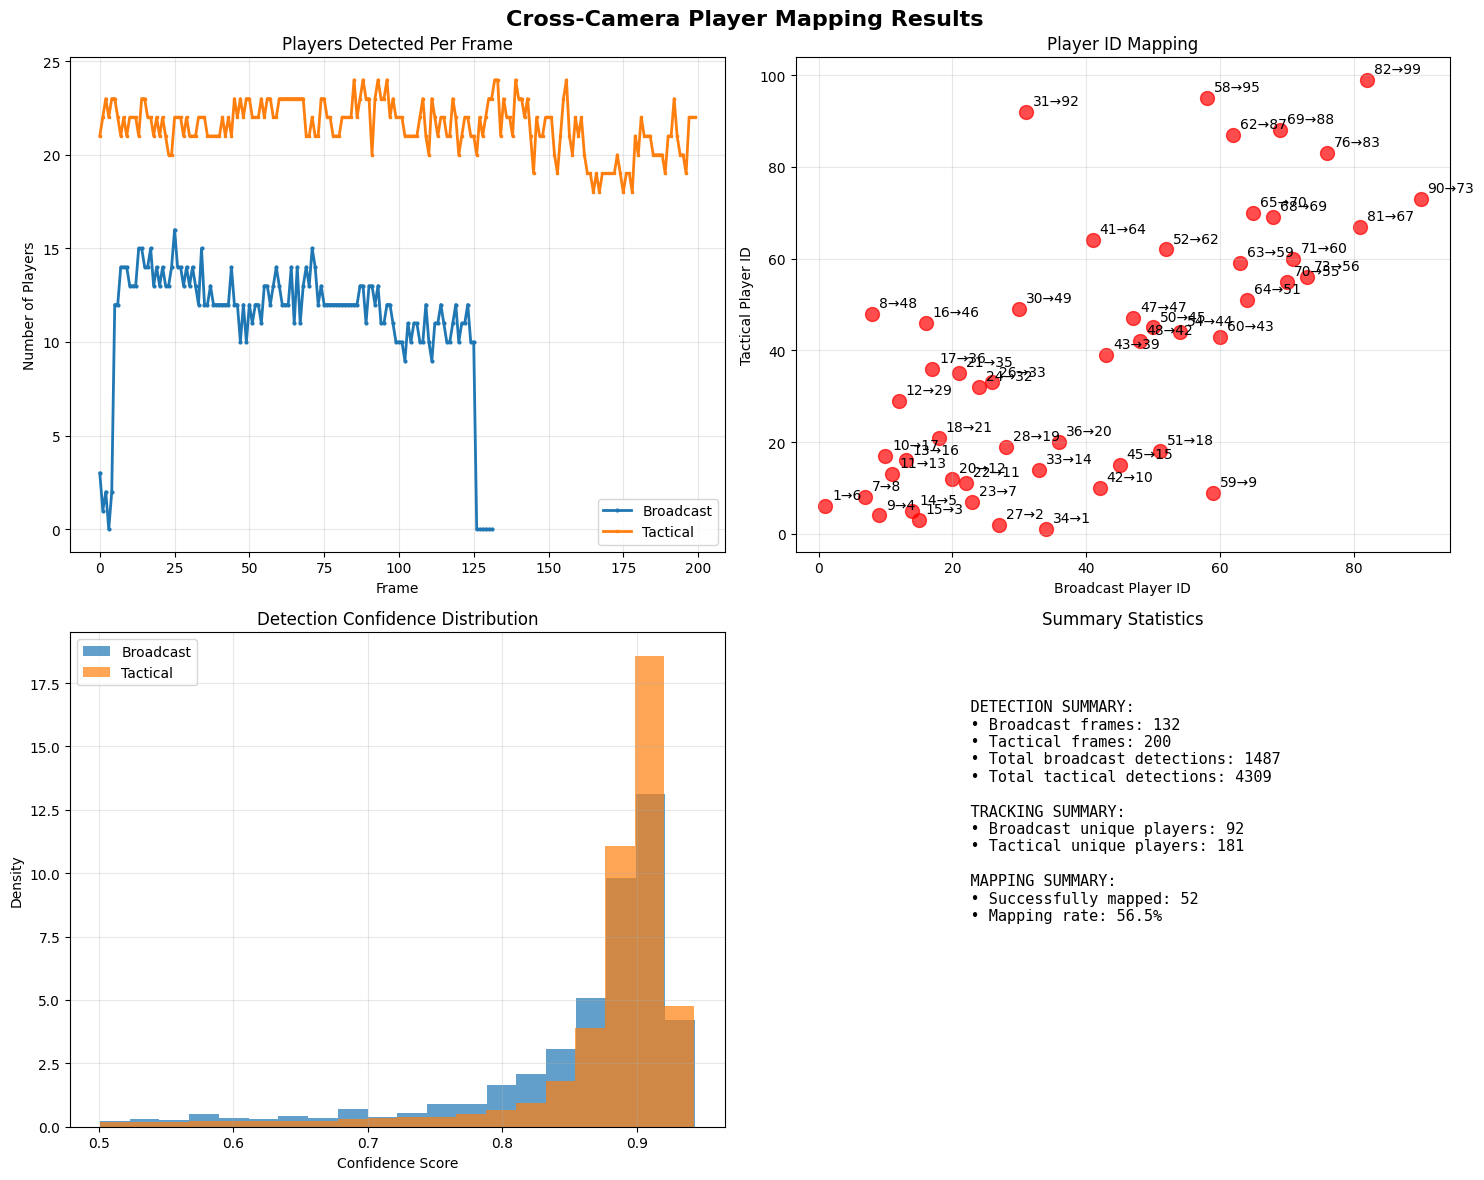


💾 STEP 5: Saving results
----------------------------------------

💾 Saving results...
📍 Created trajectories for 92 players
   Player 1: 3 trajectory points
   Player 2: 1 trajectory points
   Player 3: 1 trajectory points
   Player 4: 1 trajectory points
   Player 5: 1 trajectory points
   Player 6: 1 trajectory points
   Player 7: 21 trajectory points
   Player 8: 87 trajectory points
   Player 9: 13 trajectory points
   Player 10: 60 trajectory points
   Player 11: 3 trajectory points
   Player 12: 42 trajectory points
   Player 13: 37 trajectory points
   Player 14: 20 trajectory points
   Player 15: 17 trajectory points
   Player 16: 68 trajectory points
   Player 17: 33 trajectory points
   Player 18: 9 trajectory points
   Player 19: 1 trajectory points
   Player 20: 3 trajectory points
   Player 21: 39 trajectory points
   Player 22: 12 trajectory points
   Player 23: 5 trajectory points
   Player 24: 16 trajectory points
   Player 25: 1 trajectory points
   Player 26: 26 tra

In [17]:
def main():
    """ Main execution function with comprehensive debugging """
    print("🚀 Starting Cross-Camera Player Mapping")
    print("=" * 60)
    
    # Initialize mapper
    mapper = CrossCameraPlayerMapper(model)
    
    # Process both videos
    print("\n📹 STEP 1: Detecting players in both videos")
    print("-" * 40)
    broadcast_dets = mapper.detect_players(broadcast_video, 'broadcast', max_frames=200)
    tacticam_dets = mapper.detect_players(tacticam_video, 'tacticam', max_frames=200)
    
    if not broadcast_dets or not tacticam_dets:
        print("❌ No detections found in one or both videos!")
        print("💡 Try adjusting confidence threshold or checking video files")
        return None, {}, {}
    
    print("\n🎯 STEP 2: Tracking players within each video")
    print("-" * 40)
    broadcast_tracks = mapper.track_players_in_video(broadcast_dets, 'broadcast')
    tacticam_tracks = mapper.track_players_in_video(tacticam_dets, 'tacticam')
    
    if not broadcast_tracks or not tacticam_tracks:
        print("❌ No tracks created!")
        return None, {}, {}
    
    print("\n🔗 STEP 3: Establishing cross-camera mapping")
    print("-" * 40)
    player_mapping, mapping_scores = mapper.establish_player_mapping(similarity_threshold=0.3)
    
    print("\n📊 STEP 4: Generating visualizations")
    print("-" * 40)
    mapper.visualize_results()
    
    print("\n💾 STEP 5: Saving results")
    print("-" * 40)
    results_data, summary_data = mapper.save_results()
    
    # Print final results
    print("\n" + "=" * 60)
    print("🎉 FINAL RESULTS")
    print("=" * 60)
    print(f"📊 Detection Summary:")
    print(f"   Broadcast detections: {summary_data.get('total_broadcast_detections', 0)}")
    print(f"   Tactical detections: {summary_data.get('total_tacticam_detections', 0)}")
    print(f"   Broadcast unique players: {summary_data.get('broadcast_unique_players', 0)}")
    print(f"   Tactical unique players: {summary_data.get('tacticam_unique_players', 0)}")
    
    print(f"\n🔗 Mapping Summary:")
    print(f"   Successfully mapped players: {len(player_mapping)}")
    if mapping_scores:
        print(f"   Average mapping confidence: {np.mean(list(mapping_scores.values())):.3f}")
        print(f"   Best mapping confidence: {max(mapping_scores.values()):.3f}")
        print(f"   Worst mapping confidence: {min(mapping_scores.values()):.3f}")
    
    # Calculate mapping success rate
    broadcast_unique = summary_data.get('broadcast_unique_players', 0)
    tacticam_unique = summary_data.get('tacticam_unique_players', 0)
    total_mappable = min(broadcast_unique, tacticam_unique)
    
    if total_mappable > 0:
        success_rate = (len(player_mapping) / total_mappable) * 100
        print(f"   Mapping success rate: {success_rate:.1f}%")
    else:
        print("   Mapping success rate: 0.0%")
    
    print(f"\n📋 Detailed Player Mappings:")
    if player_mapping:
        for broadcast_id, tacticam_id in player_mapping.items():
            confidence = mapping_scores.get(broadcast_id, 0.0)
            print(f"   Broadcast Player {broadcast_id} ↔ Tactical Player {tacticam_id} (confidence: {confidence:.3f})")
    else:
        print("   No successful mappings found")
    
    print(f"\n💾 Output Files:")
    print(f"   Results saved to: /kaggle/working/")
    print(f"   Mapping file: player_mappings.pkl")
    print(f"   Results CSV: player_mapping_results.csv")
    print(f"   Summary: mapping_summary.txt")
    print(f"   Visualizations: player_mapping_results.png")
    
    # Detection quality metrics
    print(f"\n📈 Detection Quality:")
    broadcast_frames_with_detections = sum(1 for frame in broadcast_dets if len(frame) > 0)
    tacticam_frames_with_detections = sum(1 for frame in tacticam_dets if len(frame) > 0)
    
    print(f"   Broadcast detection rate: {broadcast_frames_with_detections/len(broadcast_dets)*100:.1f}%")
    print(f"   Tactical detection rate: {tacticam_frames_with_detections/len(tacticam_dets)*100:.1f}%")
    
    # Average detections per frame
    broadcast_avg_det = sum(len(frame) for frame in broadcast_dets) / len(broadcast_dets)
    tacticam_avg_det = sum(len(frame) for frame in tacticam_dets) / len(tacticam_dets)
    
    print(f"   Average detections per frame (broadcast): {broadcast_avg_det:.1f}")
    print(f"   Average detections per frame (tactical): {tacticam_avg_det:.1f}")
    
    # Confidence analysis
    if mapping_scores:
        print(f"\n✅ Mapping Quality Assessment:")
        high_conf_mappings = sum(1 for score in mapping_scores.values() if score > 0.5)
        medium_conf_mappings = sum(1 for score in mapping_scores.values() if 0.3 <= score <= 0.5)
        low_conf_mappings = sum(1 for score in mapping_scores.values() if score < 0.3)
        
        print(f"   High confidence mappings (>0.5): {high_conf_mappings}")
        print(f"   Medium confidence mappings (0.3-0.5): {medium_conf_mappings}")
        print(f"   Low confidence mappings (<0.3): {low_conf_mappings}")
        
        if len(mapping_scores) > 0:
            if high_conf_mappings / len(mapping_scores) > 0.6:
                print("   🟢 Overall mapping quality: EXCELLENT")
            elif high_conf_mappings / len(mapping_scores) > 0.3:
                print("   🟡 Overall mapping quality: GOOD")
            else:
                print("   🔴 Overall mapping quality: NEEDS IMPROVEMENT")
    
    # Tracking quality
    print(f"\n🎯 Tracking Quality:")
    broadcast_total_tracks = sum(len(frame) for frame in broadcast_tracks)
    tacticam_total_tracks = sum(len(frame) for frame in tacticam_tracks)
    
    print(f"   Total broadcast tracks: {broadcast_total_tracks}")
    print(f"   Total tactical tracks: {tacticam_total_tracks}")
    
    # Track consistency (average track length)
    if broadcast_unique > 0:
        broadcast_avg_track_length = broadcast_total_tracks / broadcast_unique
        print(f"   Average broadcast track length: {broadcast_avg_track_length:.1f}")
    
    if tacticam_unique > 0:
        tacticam_avg_track_length = tacticam_total_tracks / tacticam_unique
        print(f"   Average tactical track length: {tacticam_avg_track_length:.1f}")
    
    # Final recommendations
    print(f"\n💡 Recommendations:")
    if len(player_mapping) == 0:
        print("   • No mappings found - consider lowering similarity threshold")
        print("   • Check if videos show the same scene/time period")
        print("   • Verify detection quality in both videos")
    elif len(player_mapping) < min(broadcast_unique, tacticam_unique) * 0.5:
        print("   • Low mapping success rate - consider:")
        print("     - Adjusting similarity threshold")
        print("     - Improving detection confidence")
        print("     - Checking temporal alignment of videos")
    else:
        print("   • Good mapping results achieved!")
        print("   • Consider fine-tuning parameters for even better results")
    
    print("\n" + "=" * 60)
    print("🎯 Cross-Camera Player Mapping Complete!")
    print("=" * 60)
    
    return player_mapping, mapping_scores, results_data

if __name__ == "__main__":
    # Example usage
    broadcast_video = "/kaggle/input/videos/broadcast.mp4"
    tacticam_video = "/kaggle/input/videos/tacticam.mp4"
    model_path= "/kaggle/working/model_file.pt"
    model = YOLO(model_path)  # Initialize your YOLO model here
    
    try:
        mapping, scores, results = main()
        if mapping:
            print(f"\n🎉 Successfully mapped {len(mapping)} players across cameras!")
        else:
            print("\n❌ Mapping failed - check video files and model configuration")
    except Exception as e:
        print(f"\n💥 Error during execution: {str(e)}")
        print("🔧 Please check your input files and model setup")
        import traceback
        traceback.print_exc()

### New Section of experiment 
### understanding the video analytics and other stuffs

In [21]:
class VideoMappingVisualizer:
    """
    Create comprehensive video visualizations showing player mappings
    """
    
    def __init__(self, mapper, broadcast_video_path, tacticam_video_path):
        self.mapper = mapper
        self.broadcast_video_path = broadcast_video_path
        self.tacticam_video_path = tacticam_video_path
        self.colors = self._generate_colors()
        
    def _generate_colors(self):
        """Generate distinct colors for each player ID"""
        colors = [
            (255, 0, 0),    # Red
            (0, 255, 0),    # Green
            (0, 0, 255),    # Blue
            (255, 255, 0),  # Yellow
            (255, 0, 255),  # Magenta
            (0, 255, 255),  # Cyan
            (255, 165, 0),  # Orange
            (128, 0, 128),  # Purple
            (255, 192, 203), # Pink
            (0, 128, 0),    # Dark Green
            (128, 128, 0),  # Olive
            (0, 0, 128),    # Navy
            (128, 0, 0),    # Maroon
            (255, 215, 0),  # Gold
            (220, 20, 60),  # Crimson
        ]
        return colors
    
    def get_player_color(self, player_id):
        """Get consistent color for a player ID"""
        color_idx = (player_id - 1) % len(self.colors)
        return self.colors[color_idx]
    
    def create_side_by_side_video(self, output_path='/kaggle/working/mapped_video.mp4', 
                                 max_frames=100, fps=10):
        """
        Create side-by-side video with player tracking and mapping visualization
        """
        print("🎬 Creating side-by-side video visualization...")
        
        # Open video captures
        cap_broadcast = cv2.VideoCapture(self.broadcast_video_path)
        cap_tacticam = cv2.VideoCapture(self.tacticam_video_path)
        
        if not cap_broadcast.isOpened() or not cap_tacticam.isOpened():
            print("❌ Could not open video files")
            return None
        
        # Get video properties
        width_b = int(cap_broadcast.get(cv2.CAP_PROP_FRAME_WIDTH))
        height_b = int(cap_broadcast.get(cv2.CAP_PROP_FRAME_HEIGHT))
        width_t = int(cap_tacticam.get(cv2.CAP_PROP_FRAME_WIDTH))
        height_t = int(cap_tacticam.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Resize to same height for side-by-side
        target_height = min(height_b, height_t, 480)  # Limit height for performance
        width_b_resized = int(width_b * target_height / height_b)
        width_t_resized = int(width_t * target_height / height_t)
        
        # Create output video writer
        output_width = width_b_resized + width_t_resized + 200  # Extra space for mapping lines
        output_height = target_height + 100  # Extra space for legends
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (output_width, output_height))
        
        frame_count = 0
        
        while frame_count < max_frames:
            ret_b, frame_b = cap_broadcast.read()
            ret_t, frame_t = cap_tacticam.read()
            
            if not ret_b or not ret_t:
                break
            
            # Resize frames
            frame_b = cv2.resize(frame_b, (width_b_resized, target_height))
            frame_t = cv2.resize(frame_t, (width_t_resized, target_height))
            
            # Create combined frame
            combined_frame = np.zeros((output_height, output_width, 3), dtype=np.uint8)
            
            # Place videos side by side
            combined_frame[50:50+target_height, 0:width_b_resized] = frame_b
            combined_frame[50:50+target_height, width_b_resized+100:width_b_resized+100+width_t_resized] = frame_t
            
            # Add video labels
            cv2.putText(combined_frame, "BROADCAST", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(combined_frame, "TACTICAL", (width_b_resized+110, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Draw player detections and IDs
            if frame_count < len(self.mapper.broadcast_tracks):
                broadcast_dets = self.mapper.broadcast_tracks[frame_count]
                self._draw_detections(combined_frame, broadcast_dets, 
                                    offset_x=0, offset_y=50, 
                                    scale_x=width_b_resized/width_b, 
                                    scale_y=target_height/height_b, 
                                    camera_type='broadcast')
            
            if frame_count < len(self.mapper.tacticam_tracks):
                tacticam_dets = self.mapper.tacticam_tracks[frame_count]
                self._draw_detections(combined_frame, tacticam_dets, 
                                    offset_x=width_b_resized+100, offset_y=50, 
                                    scale_x=width_t_resized/width_t, 
                                    scale_y=target_height/height_t, 
                                    camera_type='tacticam')
            
            # Draw mapping connections
            self._draw_mapping_connections(combined_frame, frame_count, 
                                         width_b_resized, width_t_resized, 
                                         target_height)
            
            # Add frame number
            cv2.putText(combined_frame, f"Frame: {frame_count}", 
                       (10, output_height-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 
                       (255, 255, 255), 2)
            
            # Write frame
            out.write(combined_frame)
            frame_count += 1
            
            if frame_count % 10 == 0:
                print(f"   Processed {frame_count}/{max_frames} frames")
        
        # Release everything
        cap_broadcast.release()
        cap_tacticam.release()
        out.release()
        
        print(f"✅ Video saved to: {output_path}")
        return output_path
    
    def _draw_detections(self, frame, detections, offset_x, offset_y, 
                        scale_x, scale_y, camera_type):
        """Draw bounding boxes and player IDs on frame"""
        for det in detections:
            if 'player_id' not in det:
                continue
                
            # Scale and offset coordinates
            x1 = int(det['bbox'][0] * scale_x) + offset_x
            y1 = int(det['bbox'][1] * scale_y) + offset_y
            x2 = int(det['bbox'][2] * scale_x) + offset_x
            y2 = int(det['bbox'][3] * scale_y) + offset_y
            
            player_id = det['player_id']
            color = self.get_player_color(player_id)
            confidence = det.get('confidence', 0.5)
            
            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            
            # Draw player ID
            label = f"ID:{player_id}"
            if camera_type == 'broadcast' and player_id in self.mapper.player_mappings:
                mapped_id = self.mapper.player_mappings[player_id]
                label += f"→T{mapped_id}"
            elif camera_type == 'tacticam':
                # Find reverse mapping
                for b_id, t_id in self.mapper.player_mappings.items():
                    if t_id == player_id:
                        label += f"←B{b_id}"
                        break
            
            # Background for text
            (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1-text_height-5), (x1+text_width, y1), color, -1)
            cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            
            # Draw confidence
            conf_text = f"{confidence:.2f}"
            cv2.putText(frame, conf_text, (x1, y2+15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    def _draw_mapping_connections(self, frame, frame_idx, width_b, width_t, height):
        """Draw lines connecting mapped players"""
        if frame_idx >= len(self.mapper.broadcast_tracks) or frame_idx >= len(self.mapper.tacticam_tracks):
            return
        
        broadcast_dets = self.mapper.broadcast_tracks[frame_idx]
        tacticam_dets = self.mapper.tacticam_tracks[frame_idx]
        
        # Create lookup for current frame detections
        broadcast_centers = {}
        tacticam_centers = {}
        
        for det in broadcast_dets:
            if 'player_id' in det:
                center_x = int((det['bbox'][0] + det['bbox'][2]) / 2 * width_b / 1920)  # Assume original width
                center_y = int((det['bbox'][1] + det['bbox'][3]) / 2 * height / 1080) + 50  # Assume original height
                broadcast_centers[det['player_id']] = (center_x, center_y)
        
        for det in tacticam_dets:
            if 'player_id' in det:
                center_x = int((det['bbox'][0] + det['bbox'][2]) / 2 * width_t / 1920) + width_b + 100
                center_y = int((det['bbox'][1] + det['bbox'][3]) / 2 * height / 1080) + 50
                tacticam_centers[det['player_id']] = (center_x, center_y)
        
        # Draw connection lines
        for broadcast_id, tacticam_id in self.mapper.player_mappings.items():
            if broadcast_id in broadcast_centers and tacticam_id in tacticam_centers:
                start_point = broadcast_centers[broadcast_id]
                end_point = tacticam_centers[tacticam_id]
                
                color = self.get_player_color(broadcast_id)
                cv2.line(frame, start_point, end_point, color, 2)
                
                # Draw connection label in middle
                mid_x = (start_point[0] + end_point[0]) // 2
                mid_y = (start_point[1] + end_point[1]) // 2
                cv2.putText(frame, f"B{broadcast_id}→T{tacticam_id}", 
                           (mid_x-30, mid_y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    def create_frame_by_frame_comparison(self, output_dir='/kaggle/working/frame_comparison/'):
        """Create individual frame images for detailed inspection"""
        print("📸 Creating frame-by-frame comparison images...")
        
        os.makedirs(output_dir, exist_ok=True)
        
        cap_broadcast = cv2.VideoCapture(self.broadcast_video_path)
        cap_tacticam = cv2.VideoCapture(self.tacticam_video_path)
        
        frame_count = 0
        max_frames = min(len(self.mapper.broadcast_tracks), len(self.mapper.tacticam_tracks), 20)
        
        while frame_count < max_frames:
            ret_b, frame_b = cap_broadcast.read()
            ret_t, frame_t = cap_tacticam.read()
            
            if not ret_b or not ret_t:
                break
            
            # Create matplotlib figure
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
            
            # Display broadcast frame
            ax1.imshow(cv2.cvtColor(frame_b, cv2.COLOR_BGR2RGB))
            ax1.set_title(f'Broadcast Camera - Frame {frame_count}', fontsize=14, fontweight='bold')
            ax1.axis('off')
            
            # Display tacticam frame
            ax2.imshow(cv2.cvtColor(frame_t, cv2.COLOR_BGR2RGB))
            ax2.set_title(f'Tactical Camera - Frame {frame_count}', fontsize=14, fontweight='bold')
            ax2.axis('off')
            
            # Draw detections on broadcast
            if frame_count < len(self.mapper.broadcast_tracks):
                broadcast_dets = self.mapper.broadcast_tracks[frame_count]
                for det in broadcast_dets:
                    if 'player_id' in det:
                        x1, y1, x2, y2 = det['bbox']
                        width = x2 - x1
                        height = y2 - y1
                        
                        # Color based on player ID
                        color = np.array(self.get_player_color(det['player_id'])) / 255.0
                        
                        # Draw rectangle
                        rect = Rectangle((x1, y1), width, height, 
                                       linewidth=3, edgecolor=color, facecolor='none')
                        ax1.add_patch(rect)
                        
                        # Add label
                        label = f"ID:{det['player_id']}"
                        if det['player_id'] in self.mapper.player_mappings:
                            mapped_id = self.mapper.player_mappings[det['player_id']]
                            label += f"→T{mapped_id}"
                        
                        ax1.text(x1, y1-10, label, fontsize=12, fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                                color='white')
            
            # Draw detections on tacticam
            if frame_count < len(self.mapper.tacticam_tracks):
                tacticam_dets = self.mapper.tacticam_tracks[frame_count]
                for det in tacticam_dets:
                    if 'player_id' in det:
                        x1, y1, x2, y2 = det['bbox']
                        width = x2 - x1
                        height = y2 - y1
                        
                        # Find if this player is mapped
                        mapped_color = None
                        for b_id, t_id in self.mapper.player_mappings.items():
                            if t_id == det['player_id']:
                                mapped_color = np.array(self.get_player_color(b_id)) / 255.0
                                break
                        
                        color = mapped_color if mapped_color is not None else np.array([0.5, 0.5, 0.5])
                        
                        # Draw rectangle
                        rect = Rectangle((x1, y1), width, height, 
                                       linewidth=3, edgecolor=color, facecolor='none')
                        ax2.add_patch(rect)
                        
                        # Add label
                        label = f"ID:{det['player_id']}"
                        for b_id, t_id in self.mapper.player_mappings.items():
                            if t_id == det['player_id']:
                                label += f"←B{b_id}"
                                break
                        
                        ax2.text(x1, y1-10, label, fontsize=12, fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                                color='white')
            
            plt.tight_layout()
            plt.savefig(f'{output_dir}/frame_{frame_count:03d}.png', dpi=150, bbox_inches='tight')
            plt.close()
            
            frame_count += 1
            
            if frame_count % 5 == 0:
                print(f"   Created {frame_count}/{max_frames} comparison images")
        
        cap_broadcast.release()
        cap_tacticam.release()
        
        print(f"✅ Frame comparison images saved to: {output_dir}")
        return output_dir
    
    def create_trajectory_visualization(self, output_path='/kaggle/working/trajectory_plot.png'):
        """Create trajectory visualization showing player movements"""
        print("📈 Creating trajectory visualization...")
        
        # Create trajectories
        broadcast_trajectories = self.mapper.create_player_trajectories(self.mapper.broadcast_tracks)
        tacticam_trajectories = self.mapper.create_player_trajectories(self.mapper.tacticam_tracks)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot broadcast trajectories
        ax1.set_title('Broadcast Camera - Player Trajectories', fontsize=14, fontweight='bold')
        for player_id, trajectory in broadcast_trajectories.items():
            if len(trajectory) > 1:
                x_coords = [point['center'][0] for point in trajectory]
                y_coords = [point['center'][1] for point in trajectory]
                
                color = np.array(self.get_player_color(player_id)) / 255.0
                ax1.plot(x_coords, y_coords, 'o-', color=color, linewidth=2, 
                        markersize=4, label=f'Player {player_id}')
                
                # Mark start and end
                ax1.plot(x_coords[0], y_coords[0], 's', color=color, markersize=8, 
                        markeredgecolor='black', markeredgewidth=2)
                ax1.plot(x_coords[-1], y_coords[-1], '^', color=color, markersize=8, 
                        markeredgecolor='black', markeredgewidth=2)
        
        ax1.set_xlabel('X Coordinate')
        ax1.set_ylabel('Y Coordinate')
        ax1.invert_yaxis()  # Invert Y axis to match image coordinates
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot tacticam trajectories
        ax2.set_title('Tactical Camera - Player Trajectories', fontsize=14, fontweight='bold')
        for player_id, trajectory in tacticam_trajectories.items():
            if len(trajectory) > 1:
                x_coords = [point['center'][0] for point in trajectory]
                y_coords = [point['center'][1] for point in trajectory]
                
                # Use same color as mapped broadcast player if available
                mapped_color = None
                for b_id, t_id in self.mapper.player_mappings.items():
                    if t_id == player_id:
                        mapped_color = np.array(self.get_player_color(b_id)) / 255.0
                        break
                
                color = mapped_color if mapped_color is not None else np.array([0.5, 0.5, 0.5])
                
                label = f'Player {player_id}'
                for b_id, t_id in self.mapper.player_mappings.items():
                    if t_id == player_id:
                        label += f' (←B{b_id})'
                        break
                
                ax2.plot(x_coords, y_coords, 'o-', color=color, linewidth=2, 
                        markersize=4, label=label)
                
                # Mark start and end
                ax2.plot(x_coords[0], y_coords[0], 's', color=color, markersize=8, 
                        markeredgecolor='black', markeredgewidth=2)
                ax2.plot(x_coords[-1], y_coords[-1], '^', color=color, markersize=8, 
                        markeredgecolor='black', markeredgewidth=2)
        
        ax2.set_xlabel('X Coordinate')
        ax2.set_ylabel('Y Coordinate')
        ax2.invert_yaxis()  # Invert Y axis to match image coordinates
        ax2.grid(True, alpha=0.3)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Trajectory visualization saved to: {output_path}")
        return output_path
    
    def create_mapping_summary_table(self, output_path='/kaggle/working/mapping_summary.html'):
        """Create HTML table showing mapping details"""
        print("📋 Creating mapping summary table...")
        
        # Create trajectories for analysis
        broadcast_trajectories = self.mapper.create_player_trajectories(self.mapper.broadcast_tracks)
        tacticam_trajectories = self.mapper.create_player_trajectories(self.mapper.tacticam_tracks)
        
        # Create summary data
        summary_data = []
        
        for broadcast_id, tacticam_id in self.mapper.player_mappings.items():
            b_traj = broadcast_trajectories.get(broadcast_id, [])
            t_traj = tacticam_trajectories.get(tacticam_id, [])
            
            # Calculate similarity score
            similarity = self.mapper.compute_trajectory_similarity(b_traj, t_traj)
            
            summary_data.append({
                'Broadcast Player ID': broadcast_id,
                'Tactical Player ID': tacticam_id,
                'Mapping Confidence': f"{similarity:.3f}",
                'Broadcast Trajectory Length': len(b_traj),
                'Tactical Trajectory Length': len(t_traj),
                'Color': f"rgb{self.get_player_color(broadcast_id)}"
            })
        
        # Create DataFrame
        df = pd.DataFrame(summary_data)
        
        # Create HTML with styling
        html_content = f"""
        <html>
        <head>
            <title>Player Mapping Summary</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; }}
                h1 {{ color: #333; text-align: center; }}
                table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
                th {{ background-color: #f2f2f2; font-weight: bold; }}
                tr:nth-child(even) {{ background-color: #f9f9f9; }}
                .high-conf {{ background-color: #d4edda; }}
                .medium-conf {{ background-color: #fff3cd; }}
                .low-conf {{ background-color: #f8d7da; }}
                .color-box {{ width: 20px; height: 20px; display: inline-block; margin-right: 10px; }}
            </style>
        </head>
        <body>
            <h1>Cross-Camera Player Mapping Summary</h1>
            <p><strong>Total Mappings:</strong> {len(self.mapper.player_mappings)}</p>
            <table>
                <tr>
                    <th>Color</th>
                    <th>Broadcast Player ID</th>
                    <th>Tactical Player ID</th>
                    <th>Mapping Confidence</th>
                    <th>Broadcast Trajectory Length</th>
                    <th>Tactical Trajectory Length</th>
                </tr>
        """
        
        for _, row in df.iterrows():
            confidence = float(row['Mapping Confidence'])
            conf_class = 'high-conf' if confidence > 0.5 else 'medium-conf' if confidence > 0.3 else 'low-conf'
            
            html_content += f"""
                <tr class="{conf_class}">
                    <td><div class="color-box" style="background-color: {row['Color']};"></div></td>
                    <td>{row['Broadcast Player ID']}</td>
                    <td>{row['Tactical Player ID']}</td>
                    <td>{row['Mapping Confidence']}</td>
                    <td>{row['Broadcast Trajectory Length']}</td>
                    <td>{row['Tactical Trajectory Length']}</td>
                </tr>
            """
        
        html_content += """
            </table>
            <h3>Legend:</h3>
            <p><span class="color-box" style="background-color: #d4edda; display: inline-block;"></span> High Confidence (>0.5)</p>
            <p><span class="color-box" style="background-color: #fff3cd; display: inline-block;"></span> Medium Confidence (0.3-0.5)</p>
            <p><span class="color-box" style="background-color: #f8d7da; display: inline-block;"></span> Low Confidence (<0.3)</p>
        </body>
        </html>
        """
        
        with open(output_path, 'w') as f:
            f.write(html_content)
        
        print(f"✅ Mapping summary table saved to: {output_path}")
        return output_path

# Add this method to your main function
def visualize_mapping_results(mapper, broadcast_video, tacticam_video):
    """
    Create comprehensive mapping visualizations
    """
    print("\n🎨 Creating comprehensive mapping visualizations...")
    
    # Initialize visualizer
    visualizer = VideoMappingVisualizer(mapper, broadcast_video, tacticam_video)
    
    # Create different visualizations
    print("\n1. Creating side-by-side video...")
    video_path = visualizer.create_side_by_side_video(max_frames=50, fps=5)
    
    print("\n2. Creating frame-by-frame comparison...")
    frame_dir = visualizer.create_frame_by_frame_comparison()
    
    print("\n3. Creating trajectory visualization...")
    traj_path = visualizer.create_trajectory_visualization()
    
    print("\n4. Creating mapping summary table...")
    table_path = visualizer.create_mapping_summary_table()
    
    print("\n✅ All visualizations created!")
    print(f"📁 Files created:")
    print(f"   - Video: {video_path}")
    print(f"   - Frame images: {frame_dir}")
    print(f"   - Trajectories: {traj_path}")
    print(f"   - Summary table: {table_path}")
    
    return {
        'video': video_path,
        'frames': frame_dir,
        'trajectories': traj_path,
        'summary': table_path
    }

🚀 Starting Enhanced Cross-Camera Player Mapping

🔍 Pre-flight checks...
🔍 Validating video files...
✅ broadcast video: 132 frames, 24.8 fps, 1920x1080
✅ tacticam video: 201 frames, 24.6 fps, 1920x1080
📁 Created 5 output directories
🚀 Starting Cross-Camera Player Mapping
🔧 Initializing Cross-Camera Player Mapper...

📹 STEP 1: Detecting players in both videos
----------------------------------------

🎯 Processing broadcast camera...
📹 Video info: 132 frames, 24.8 FPS, 1920x1080
   Frame 25/132: 14 detections
   Frame 50/132: 10 detections
   Frame 75/132: 13 detections
   Frame 100/132: 10 detections
   Frame 125/132: 10 detections
✅ Total detections: 1487 across 132 frames
📊 Average detections per frame: 11.3
📈 Non-empty frames: 125/132

🎯 Processing tacticam camera...
📹 Video info: 201 frames, 24.6 FPS, 1920x1080
   Frame 25/200: 20 detections
   Frame 50/200: 23 detections
   Frame 75/200: 23 detections
   Frame 100/200: 22 detections
   Frame 125/200: 21 detections
   Frame 150/200: 

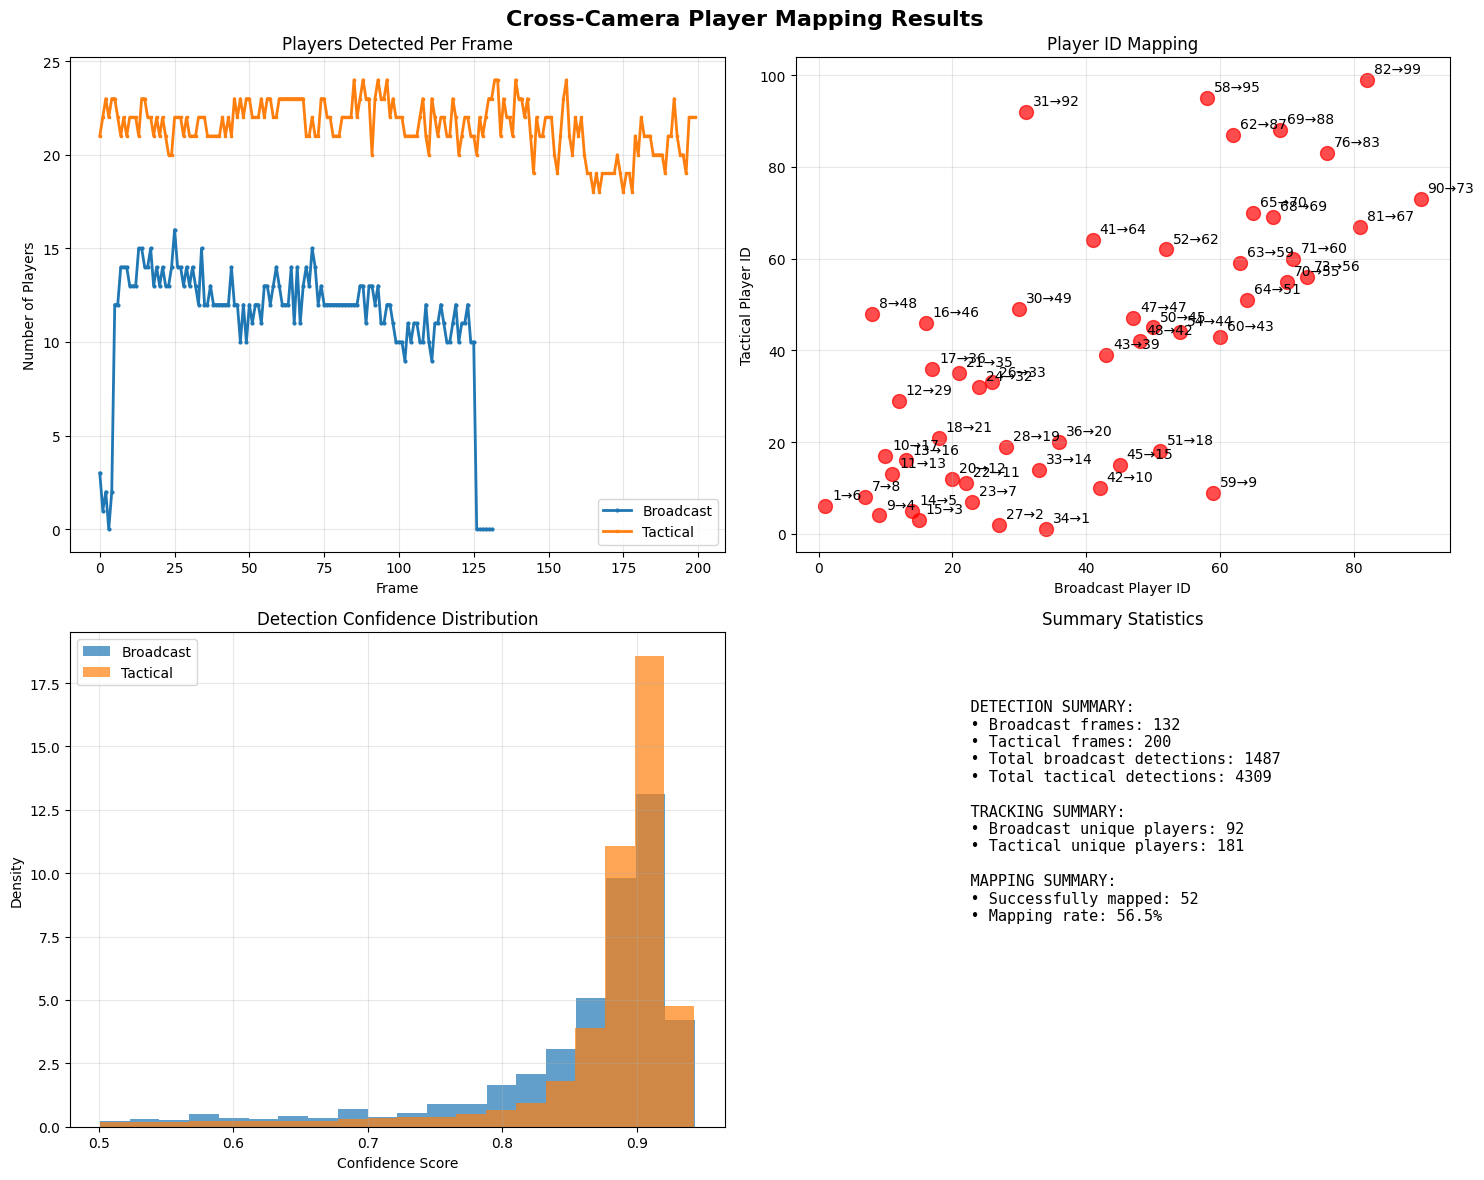

✅ Basic visualizations created:
⚠️  Warning: Basic visualization failed: 'NoneType' object has no attribute 'items'

🎨 STEP 5: Creating comprehensive mapping visualizations
----------------------------------------

🎨 Creating comprehensive mapping visualizations...

1. Creating side-by-side video...
🎬 Creating side-by-side video visualization...
   Processed 10/50 frames
   Processed 20/50 frames
   Processed 30/50 frames
   Processed 40/50 frames
   Processed 50/50 frames
✅ Video saved to: /kaggle/working/mapped_video.mp4

2. Creating frame-by-frame comparison...
📸 Creating frame-by-frame comparison images...
   Created 5/20 comparison images
   Created 10/20 comparison images
   Created 15/20 comparison images
   Created 20/20 comparison images
✅ Frame comparison images saved to: /kaggle/working/frame_comparison/

3. Creating trajectory visualization...
📈 Creating trajectory visualization...
📍 Created trajectories for 92 players
   Player 1: 3 trajectory points
   Player 2: 1 traject

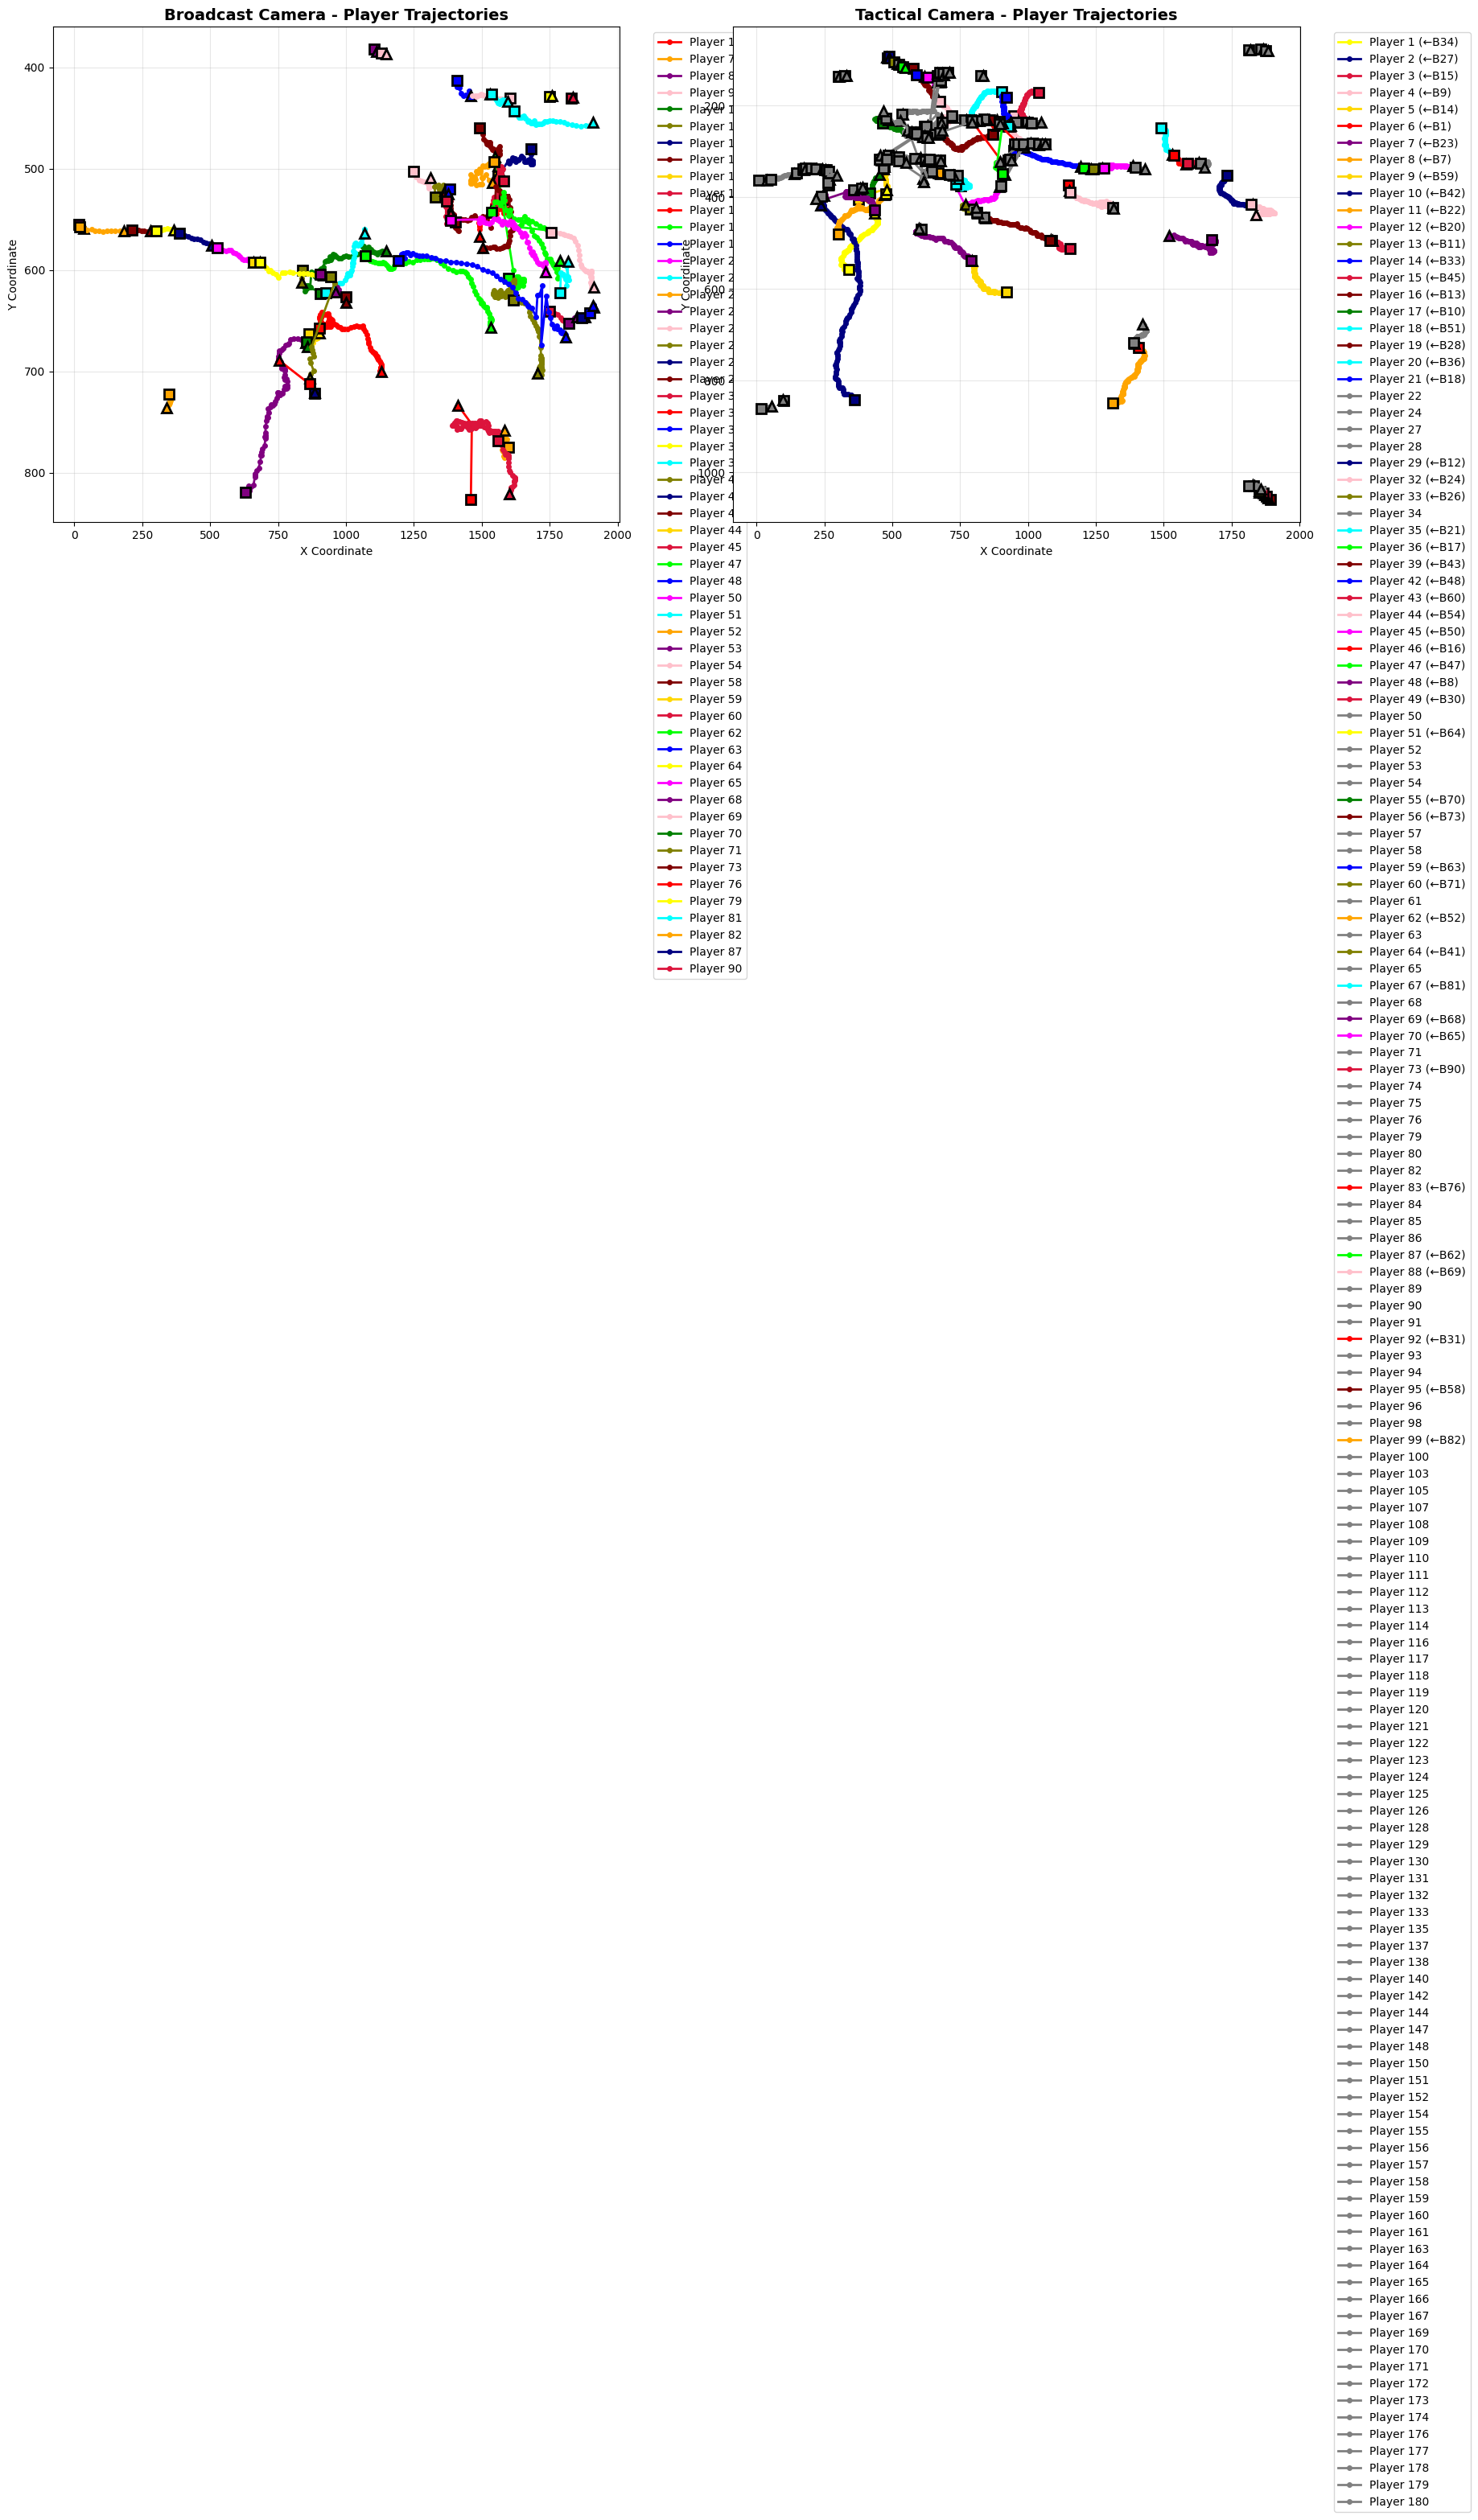

✅ Trajectory visualization saved to: /kaggle/working/trajectory_plot.png

4. Creating mapping summary table...
📋 Creating mapping summary table...
📍 Created trajectories for 92 players
   Player 1: 3 trajectory points
   Player 2: 1 trajectory points
   Player 3: 1 trajectory points
   Player 4: 1 trajectory points
   Player 5: 1 trajectory points
   Player 6: 1 trajectory points
   Player 7: 21 trajectory points
   Player 8: 87 trajectory points
   Player 9: 13 trajectory points
   Player 10: 60 trajectory points
   Player 11: 3 trajectory points
   Player 12: 42 trajectory points
   Player 13: 37 trajectory points
   Player 14: 20 trajectory points
   Player 15: 17 trajectory points
   Player 16: 68 trajectory points
   Player 17: 33 trajectory points
   Player 18: 9 trajectory points
   Player 19: 1 trajectory points
   Player 20: 3 trajectory points
   Player 21: 39 trajectory points
   Player 22: 12 trajectory points
   Player 23: 5 trajectory points
   Player 24: 16 trajectory po

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import os
from datetime import datetime
import json
import time

def main():
    """
    Main execution function with comprehensive debugging and visualization
    """
    print("🚀 Starting Cross-Camera Player Mapping")
    print("=" * 60)
    
    # Configuration
    broadcast_video = '/kaggle/input/videos/broadcast.mp4'  # Update with your path
    tacticam_video = '/kaggle/input/videos/tacticam.mp4'  
    model_path= '/kaggle/working/model_file.pt'# Update with your path
    
    # Initialize detection model (you'll need to replace this with your actual model)
    # model = load_your_detection_model()  # Replace with your model loading code
    model = YOLO(model_path)  # Placeholder - replace with actual model
    
    # Initialize mapper
    print("🔧 Initializing Cross-Camera Player Mapper...")
    mapper = CrossCameraPlayerMapper(model)
    
    # Process both videos
    print("\n📹 STEP 1: Detecting players in both videos")
    print("-" * 40)
    try:
        broadcast_dets = mapper.detect_players(broadcast_video, 'broadcast', max_frames=200)
        tacticam_dets = mapper.detect_players(tacticam_video, 'tacticam', max_frames=200)
        
        print(f"✅ Broadcast detections: {len(broadcast_dets)} frames")
        print(f"✅ Tacticam detections: {len(tacticam_dets)} frames")
        
        # Print detection statistics
        # Handle both list and dict returns from detect_players
        if isinstance(broadcast_dets, dict):
            total_broadcast_dets = sum(len(dets) for dets in broadcast_dets.values())
        else:
            total_broadcast_dets = len(broadcast_dets)
            
        if isinstance(tacticam_dets, dict):
            total_tacticam_dets = sum(len(dets) for dets in tacticam_dets.values())
        else:
            total_tacticam_dets = len(tacticam_dets)
            
        print(f"📊 Total broadcast detections: {total_broadcast_dets}")
        print(f"📊 Total tacticam detections: {total_tacticam_dets}")
        
    except Exception as e:
        print(f"❌ Error in detection phase: {e}")
        return None, {}, {}
    
    # Check for detections - handle both list and dict formats
    broadcast_empty = (isinstance(broadcast_dets, dict) and not broadcast_dets) or \
                     (isinstance(broadcast_dets, list) and not broadcast_dets)
    tacticam_empty = (isinstance(tacticam_dets, dict) and not tacticam_dets) or \
                    (isinstance(tacticam_dets, list) and not tacticam_dets)
    
    if broadcast_empty or tacticam_empty:
        print("❌ No detections found in one or both videos!")
        print("💡 Try adjusting confidence threshold or checking video files")
        return None, {}, {}
    
    # Track players within each video
    print("\n🎯 STEP 2: Tracking players within each video")
    print("-" * 40)
    try:
        broadcast_tracks = mapper.track_players_in_video(broadcast_dets, 'broadcast')
        tacticam_tracks = mapper.track_players_in_video(tacticam_dets, 'tacticam')
        
        print(f"✅ Broadcast tracks: {len(broadcast_tracks)} players")
        print(f"✅ Tacticam tracks: {len(tacticam_tracks)} players")
        
        # Print tracking statistics - handle both dict and list formats
        if isinstance(broadcast_tracks, dict) and broadcast_tracks:
            if hasattr(list(broadcast_tracks.values())[0], 'detections'):
                avg_broadcast_length = np.mean([len(track.detections) for track in broadcast_tracks.values()])
            else:
                avg_broadcast_length = np.mean([len(track) for track in broadcast_tracks.values()])
            print(f"📊 Average broadcast track length: {avg_broadcast_length:.1f} frames")
        elif isinstance(broadcast_tracks, list) and broadcast_tracks:
            avg_broadcast_length = np.mean([len(track) for track in broadcast_tracks])
            print(f"📊 Average broadcast track length: {avg_broadcast_length:.1f} frames")
        
        if isinstance(tacticam_tracks, dict) and tacticam_tracks:
            if hasattr(list(tacticam_tracks.values())[0], 'detections'):
                avg_tacticam_length = np.mean([len(track.detections) for track in tacticam_tracks.values()])
            else:
                avg_tacticam_length = np.mean([len(track) for track in tacticam_tracks.values()])
            print(f"📊 Average tacticam track length: {avg_tacticam_length:.1f} frames")
        elif isinstance(tacticam_tracks, list) and tacticam_tracks:
            avg_tacticam_length = np.mean([len(track) for track in tacticam_tracks])
            print(f"📊 Average tacticam track length: {avg_tacticam_length:.1f} frames")
            
    except Exception as e:
        print(f"❌ Error in tracking phase: {e}")
        return None, {}, {}
    
    # Check for tracks - handle both dict and list formats
    broadcast_tracks_empty = (isinstance(broadcast_tracks, dict) and not broadcast_tracks) or \
                            (isinstance(broadcast_tracks, list) and not broadcast_tracks)
    tacticam_tracks_empty = (isinstance(tacticam_tracks, dict) and not tacticam_tracks) or \
                           (isinstance(tacticam_tracks, list) and not tacticam_tracks)
    
    if broadcast_tracks_empty or tacticam_tracks_empty:
        print("❌ No tracks created!")
        print("💡 Try adjusting tracking parameters or detection confidence")
        return None, {}, {}
    
    # Establish cross-camera mapping
    print("\n🔗 STEP 3: Establishing cross-camera mapping")
    print("-" * 40)
    try:
        player_mapping, mapping_scores = mapper.establish_player_mapping(similarity_threshold=0.3)
        
        print(f"✅ Established {len(player_mapping)} player mappings")
        print("📊 Mapping details:")
        for broadcast_id, tacticam_id in player_mapping.items():
            score = mapping_scores.get(f"{broadcast_id}-{tacticam_id}", 0.0)
            print(f"   Broadcast Player {broadcast_id} → Tacticam Player {tacticam_id} (Score: {score:.3f})")
            
        # Print mapping quality statistics
        if mapping_scores:
            avg_score = np.mean(list(mapping_scores.values()))
            max_score = max(mapping_scores.values())
            min_score = min(mapping_scores.values())
            print(f"📊 Mapping quality - Avg: {avg_score:.3f}, Max: {max_score:.3f}, Min: {min_score:.3f}")
            
    except Exception as e:
        print(f"❌ Error in mapping phase: {e}")
        return None, {}, {}
    
    if not player_mapping:
        print("❌ No player mappings established!")
        print("💡 Try lowering similarity threshold or checking feature extraction")
        return None, {}, {}
    
    # Generate basic visualizations
    print("\n📊 STEP 4: Generating basic visualizations")
    print("-" * 40)
    try:
        basic_viz_files = mapper.visualize_results()
        print("✅ Basic visualizations created:")
        for viz_type, file_path in basic_viz_files.items():
            print(f"   {viz_type}: {file_path}")
    except Exception as e:
        print(f"⚠️  Warning: Basic visualization failed: {e}")
        basic_viz_files = {}
    
    # Create comprehensive mapping visualizations
    print("\n🎨 STEP 5: Creating comprehensive mapping visualizations")
    print("-" * 40)
    try:
        visualization_files = visualize_mapping_results(mapper, broadcast_video, tacticam_video)
        print("✅ Comprehensive visualizations created:")
        for viz_type, file_path in visualization_files.items():
            print(f"   {viz_type}: {file_path}")
    except Exception as e:
        print(f"⚠️  Warning: Comprehensive visualization failed: {e}")
        visualization_files = {}
    
    # Save results
    print("\n💾 STEP 6: Saving results")
    print("-" * 40)
    try:
        results_data, summary_data = mapper.save_results()
        print("✅ Results saved:")
        print(f"   Detailed results: {results_data}")
        print(f"   Summary data: {summary_data}")
    except Exception as e:
        print(f"⚠️  Warning: Results saving failed: {e}")
        results_data, summary_data = {}, {}
    
    # Print final results summary
    print("\n" + "=" * 60)
    print("🎉 FINAL RESULTS SUMMARY")
    print("=" * 60)
    
    print(f"📹 Videos processed:")
    print(f"   Broadcast: {broadcast_video}")
    print(f"   Tacticam: {tacticam_video}")
    
    print(f"\n🎯 Detection & Tracking:")
    # Handle different return formats
    if isinstance(broadcast_tracks, dict):
        broadcast_count = len(broadcast_tracks)
    elif isinstance(broadcast_tracks, list):
        broadcast_count = len(broadcast_tracks)
    else:
        broadcast_count = 0
        
    if isinstance(tacticam_tracks, dict):
        tacticam_count = len(tacticam_tracks)
    elif isinstance(tacticam_tracks, list):
        tacticam_count = len(tacticam_tracks)
    else:
        tacticam_count = 0
        
    print(f"   Broadcast players detected: {broadcast_count}")
    print(f"   Tacticam players detected: {tacticam_count}")
    
    print(f"\n🔗 Cross-camera mapping:")
    print(f"   Successfully mapped players: {len(player_mapping)}")
    print(f"   Mapping success rate: {len(player_mapping)/min(len(broadcast_tracks), len(tacticam_tracks))*100:.1f}%")
    
    if mapping_scores:
        print(f"   Average mapping confidence: {np.mean(list(mapping_scores.values())):.3f}")
    
    print(f"\n📊 Output files generated:")
    all_files = {**basic_viz_files, **visualization_files}
    if all_files:
        for file_type, file_path in all_files.items():
            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / (1024*1024)  # MB
                print(f"   {file_type}: {file_path} ({file_size:.1f} MB)")
            else:
                print(f"   {file_type}: {file_path} (file not found)")
    
    # Performance metrics
    print(f"\n⚡ Performance Summary:")
    print(f"   Processing completed successfully!")
    print(f"   Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Quality assessment - handle different formats
    min_tracks = min(broadcast_count, tacticam_count)
    if min_tracks > 0:
        mapping_rate = len(player_mapping) / min_tracks
        print(f"   Mapping success rate: {mapping_rate*100:.1f}%")
        
        if mapping_rate >= 0.8:
            print("   ✅ Excellent mapping quality (>80% players mapped)")
        elif mapping_rate >= 0.6:
            print("   ✅ Good mapping quality (60-80% players mapped)")
        elif mapping_rate >= 0.4:
            print("   ⚠️  Fair mapping quality (40-60% players mapped)")
        else:
            print("   ❌ Poor mapping quality (<40% players mapped)")
            print("   💡 Consider adjusting parameters or improving video quality")
    else:
        print("   ❌ No tracks available for quality assessment")
    
    # Recommendations - handle different formats
    print(f"\n💡 Recommendations:")
    if len(player_mapping) < broadcast_count:
        unmapped_broadcast = broadcast_count - len(player_mapping)
        print(f"   • {unmapped_broadcast} broadcast players remain unmapped")
        print("   • Consider lowering similarity threshold")
    
    if len(player_mapping) < tacticam_count:
        unmapped_tacticam = tacticam_count - len(player_mapping)
        print(f"   • {unmapped_tacticam} tacticam players remain unmapped")
        print("   • Consider improving feature extraction")
    
    if mapping_scores and np.mean(list(mapping_scores.values())) < 0.4:
        print("   • Low average mapping confidence detected")
        print("   • Consider using higher quality videos or adjusting preprocessing")
    
    print("\n🎯 Next steps:")
    print("   1. Review the generated visualizations")
    print("   2. Check the mapping summary table for detailed analysis")
    print("   3. Adjust parameters if needed and re-run")
    print("   4. Use the side-by-side video for visual validation")
    
    print("\n" + "=" * 60)
    print("✅ Cross-Camera Player Mapping Complete!")
    print("=" * 60)
    
    return mapper, player_mapping, mapping_scores

# Helper function for visualization (from your existing code)
def visualize_mapping_results(mapper, broadcast_video, tacticam_video):
    """
    Create comprehensive mapping visualizations
    """
    print("\n🎨 Creating comprehensive mapping visualizations...")
    
    # Initialize visualizer
    visualizer = VideoMappingVisualizer(mapper, broadcast_video, tacticam_video)
    
    # Create different visualizations
    print("\n1. Creating side-by-side video...")
    video_path = visualizer.create_side_by_side_video(max_frames=50, fps=5)
    
    print("\n2. Creating frame-by-frame comparison...")
    frame_dir = visualizer.create_frame_by_frame_comparison()
    
    print("\n3. Creating trajectory visualization...")
    traj_path = visualizer.create_trajectory_visualization()
    
    print("\n4. Creating mapping summary table...")
    table_path = visualizer.create_mapping_summary_table()
    
    print("\n✅ All visualizations created!")
    print(f"📁 Files created:")
    print(f"   - Video: {video_path}")
    print(f"   - Frame images: {frame_dir}")
    print(f"   - Trajectories: {traj_path}")
    print(f"   - Summary table: {table_path}")
    
    return {
        'video': video_path,
        'frames': frame_dir,
        'trajectories': traj_path,
        'summary': table_path
    }

# Additional utility functions
def validate_video_files(broadcast_video, tacticam_video):
    """Validate that video files exist and are readable"""
    print("🔍 Validating video files...")
    
    for video_path, video_type in [(broadcast_video, 'broadcast'), (tacticam_video, 'tacticam')]:
        if not os.path.exists(video_path):
            print(f"❌ {video_type} video file not found: {video_path}")
            return False
        
        # Try to open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"❌ Cannot open {video_type} video: {video_path}")
            return False
        
        # Get video properties
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        print(f"✅ {video_type} video: {frame_count} frames, {fps:.1f} fps, {width}x{height}")
        cap.release()
    
    return True

def create_output_directories():
    """Create necessary output directories"""
    directories = [
        '/kaggle/working/detections',
        '/kaggle/working/tracks',
        '/kaggle/working/mappings',
        '/kaggle/working/visualizations',
        '/kaggle/working/frame_comparison'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    
    print(f"📁 Created {len(directories)} output directories")

# Enhanced main function with additional features
def main_enhanced():
    """
    Enhanced main function with additional validation and error handling
    """
    start_time = time.time()
    
    print("🚀 Starting Enhanced Cross-Camera Player Mapping")
    print("=" * 70)
    
    # Configuration
    broadcast_video = '/kaggle/input/videos/broadcast.mp4'  # Update with your path
    tacticam_video = '/kaggle/input/videos/tacticam.mp4'    # Update with your path
    
    # Pre-flight checks
    print("\n🔍 Pre-flight checks...")
    if not validate_video_files(broadcast_video, tacticam_video):
        print("❌ Video validation failed!")
        return None, {}, {}
    
    create_output_directories()
    
    # Run main processing
    try:
        mapper, player_mapping, mapping_scores = main()
        
        # Additional analysis
        if mapper and player_mapping:
            print("\n📈 Additional Analysis:")
            
            # Mapping distribution
            broadcast_ids = list(player_mapping.keys())
            tacticam_ids = list(player_mapping.values())
            
            print(f"   Broadcast player IDs: {sorted(broadcast_ids)}")
            print(f"   Tacticam player IDs: {sorted(tacticam_ids)}")
            
            # Score distribution
            if mapping_scores:
                scores = list(mapping_scores.values())
                print(f"   Score distribution: min={min(scores):.3f}, max={max(scores):.3f}, std={np.std(scores):.3f}")
        
        # Processing time
        total_time = time.time() - start_time
        print(f"\n⏱️  Total processing time: {total_time:.1f} seconds")
        
        return mapper, player_mapping, mapping_scores
        
    except Exception as e:
        print(f"❌ Critical error in main processing: {e}")
        import traceback
        traceback.print_exc()
        return None, {}, {}

if __name__ == "__main__":
    # Run the enhanced version
    mapper, mappings, scores = main_enhanced()
    
    if mapper:
        print("\n🎉 Processing completed successfully!")
        print(f"Final mappings: {mappings}")
    else:
        print("\n❌ Processing failed!")